# Image Segmentation

* U-Net과 비슷한 구조의 모델을 설계하고, Image Segmentation을 진행
* reference: https://pasus.tistory.com/204

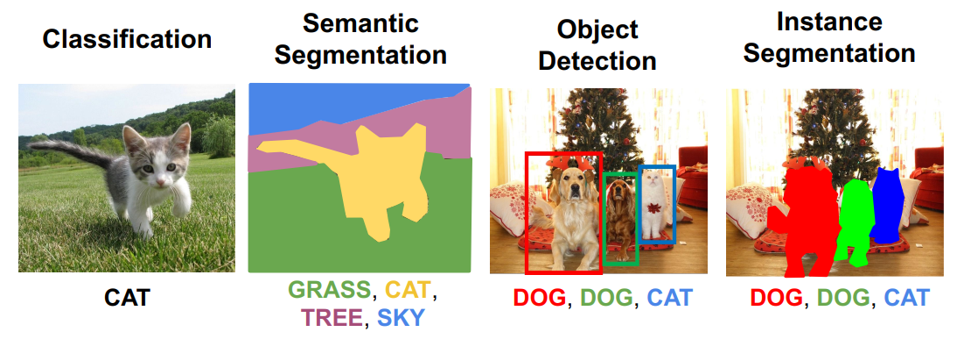

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz # 데이터셋 다운로드

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3 # 물체, 물체의 경계선, 배경 3가지 요소
batch_size = 32

# input, target path불러오기, 순서가 맞아야 하기 때문에 sorting을 하며 불러온다.
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg") # jpg 파일만 불러오기
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".") # png파일만 불러오기
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


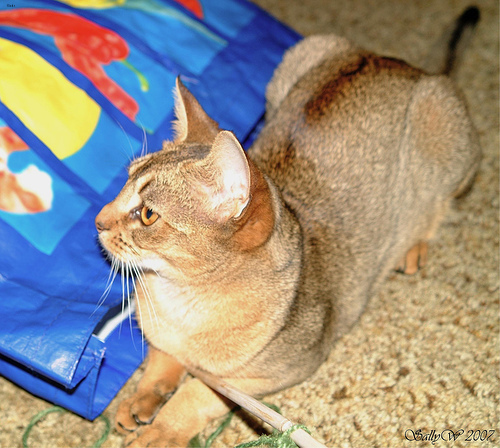

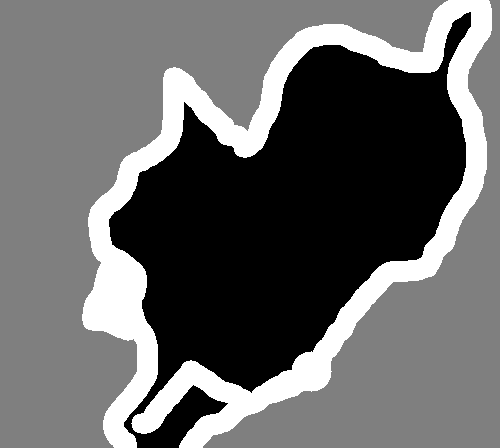

In [3]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image
display(Image(filename=input_img_paths[9])) 
# input image

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
# mask값이 1, 2, 3으로 비슷한 값을 가지고 잇기 때문에 그냥 불러오면 육안으로 확인이 어렵다.
# 따라서 auto-contrast로 annotation이 잘 되어 있는 것을 확인할 수 있다.
display(img)

In [6]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        # 주요 변수 정의
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        # Target image size를 batch size로 나눠서 iteration 횟수 결정
        return len(self.target_img_paths) // self.batch_size


    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        # i번째부터 i+batch size까지 image와 target을 불러올 수 있도록 설정
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") 
        # 0으로 이뤄진 numpy array 생성. image size로 결정. img의 size : 32, 160, 160, 3
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            # img 를 load해서 x에 잘 저장되도록 함
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale") 
            # img size : 32, 160, 160, 1
            y[j] = np.expand_dims(img, 2) # 2차원으로 이미지를 확장해줌. 그냥 불러온 이미지는 1차원 형태
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1 # 0, 1, 2로 바꾸고 싶기 때문
        return x, y

In [7]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    # U-Net 구현
    inputs = keras.Input(shape=img_size + (3,))
    # input값 설정

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        # Undersampling
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation 
        )
        x = layers.add([x, residual])  # Add back residual, 잔차를 더한다
        previous_block_activation = x  # Set aside next residual, previous_block_activation을 지금의 x로 갱신

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x) # Upsampling 진행

        # Project residual
        # 잔차를 투영해서 layer크기에 맞춤
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual, 잔차를 더한다
        previous_block_activation = x  # Set aside next residual, previous_block_activation을 지금의 x로 갱신

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session() # 램 용량 확보

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [8]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]
# 별도의 test/valiadation sample이 없기 때문에 직접 1000개의 validation sample사용

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
# Train generator, validation generator 정의

In [9]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
# 다중 클래스 분류 문제, sparse_categorial_crossentropy를 사용
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/5
199/199 [==============================] - 83s 297ms/step - loss: 1.0276 - val_loss: 1.3439
Epoch 2/5
199/199 [==============================] - 57s 288ms/step - loss: 0.5068 - val_loss: 2.5588
Epoch 3/5
199/199 [==============================] - 51s 257ms/step - loss: 0.4352 - val_loss: 0.5093
Epoch 4/5
199/199 [==============================] - 51s 258ms/step - loss: 0.3917 - val_loss: 0.4163
Epoch 5/5
199/199 [==============================] - 51s 257ms/step - loss: 0.3612 - val_loss: 0.4016


31/31 [==============================] - 7s 213ms/step


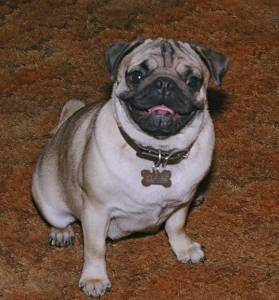

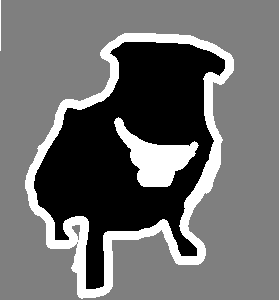

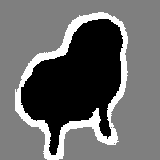

In [10]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen) # 모델에 대한 prediction 진행


def display_mask(i):
    """Quick utility to display a model's prediction."""
    # 시각화를 위한 간단한 함수
    mask = np.argmax(val_preds[i], axis=-1) # 0, 1, 2중 어떤 것인지 반환
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    # autocontrast를 통해서 확실하게 확인
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))
# 주어진 이미지

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img) 
# 실제 mask

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.
# 모델이 학습하여 내놓은 결과